In [1]:
# Development mode: automatic reloading of modules
%load_ext autoreload
%autoreload 2


In [2]:
import pickle
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool
import os
from itertools import product
import time
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

num_cpus = os.cpu_count()
print(f'cpu_count: {num_cpus}')

ModuleNotFoundError: No module named 'tc_python'

In [ ]:
basename = 'IronOxide_TC_sublattice'

current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)

Cache Filename:  IronOxide_TC_sublattice.ipynb_cache
Output Filename:  IronOxide_TC_sublattice
Current Dir:  /nethome/home3/yuxiang.wu/IronOxide_TC


### TC functions

#### `tc_calculation_FullEquil`: compute the equilibrium phase fraction as (acr, T)


In [ ]:
def tc_calculation_FullEquil(tk):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tcfe13", ["Fe", "O"])
            .deselect_phase("*")
            .select_phase("CORUNDUM SPINEL HALITE BCC_A2 GAS")
            # .select_database_and_elements("tcox10", ["Fe", "O"])
            # .deselect_phase("*")
            # .select_phase("CORUNDUM SPINEL HALITE")
            # .select_database_and_elements("ssub5", ["Fe", "O"])
            # .deselect_phase("*")
            # .select_phase("GAS")
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        results = batch_calculation.calculate(
            ["np(CORUNDUM)", "np(SPINEL)", "np(HALITE)", "np(BCC_A2)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('np(CORUNDUM)'),
            results.get_values_of('np(SPINEL)'),
            results.get_values_of('np(HALITE)'),
            results.get_values_of('np(BCC_A2)'),
        )

#### `tc_calculation_Gmin`: compute the Gibbs energy as (database, phase, acr, T)


In [ ]:
def tc_calculation_Gmin(tk, db, phase):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5))

        batch_calculation = (
            batch_calculation
            .select_database_and_elements(db, ["Fe", "O"])
            .deselect_phase("*")
            .select_phase(f"{phase} GAS")
            # .select_database_and_elements("ssub5", ["Fe", "O"])
            # .deselect_phase("*")
            # .select_phase("GAS")
        )

        # Continue with the rest of the method chain
        batch_calculation = (
            batch_calculation
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        # run a calculation first
        results = batch_calculation.calculate([f"gm({phase})"], 100)

        # # turn "GAS" into Dormant and run the same calculation again
        # batch_calculation.set_phase_to_dormant("GAS")
        # results = batch_calculation.calculate([f"gm({phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"gm({phase})")
        )

#### `tc_calculation_NormDrivingForce`: compute the Normalised Driving Force as (database, phase, acr, T)


In [ ]:
def tc_calculation_NormDrivingForce(tk, db, phase):
    with TCPython() as start:
        batch_calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
        )

        batch_calculation = (
            batch_calculation
            .select_database_and_elements(db, ["Fe", "O"])
            .deselect_phase("*")
            .select_phase(f"{phase} GAS")
            # .select_database_and_elements('ssub5', ["Fe", "O"])
            # .deselect_phase("*")
            # .select_phase("GAS")
        )

        # Continue with the rest of the method chain
        batch_calculation = (
            batch_calculation
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition("T", 100+273.15)
            .set_condition("P", 0.5)
            .set_condition("lnacr(o)", -400)
            .set_phase_to_dormant(phase)
            .with_reference_state("O", 'GAS', tk, 10000)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        k = 150
        list_of_conditions = [(("lnacr(o)", lnacr_o), ("T", tk))
                              for lnacr_o in np.linspace(-60, -5, k)]

        batch_calculation.set_conditions_for_equilibria(list_of_conditions)

        # run a calculation first
        results = batch_calculation.calculate([f"dgm({phase})"], 100)

        return (
            list_of_conditions,
            results.get_values_of(f"dgm({phase})")
        )

### Parallelising TC calculation


In [ ]:
start_time = time.time()

# paralleising FullEquil
tk_values = np.arange(0+273.15, 605+273.15, 5)
print("temperature range first and last 5 values: ",
      tk_values[:5], tk_values[-5:])
print("FullEquil processes: ", len(tk_values))

# parallelising Gmin and DGM
databases_phases = {
    "tcfe13": ["CORUNDUM", "SPINEL", "HALITE", "BCC_A2"]
}

Gmin_DGM_args = []
for tk in tk_values:
    for db, phases in databases_phases.items():
        for phase in phases:
            Gmin_DGM_args.append((tk, db, phase))

print("args for Gmin/DGM parallelisation: ",
      Gmin_DGM_args[:5])
print("Gmin/DGM processes: ", len(Gmin_DGM_args))

# %%%%% load data or run calculations %%%%%
try:
    with open(basename + "_FullEquil_results.pkl", "rb") as f:
        FullEquil_results = pickle.load(f)
    with open(basename + "_Gmin_results.pkl", "rb") as f:
        Gmin_results = pickle.load(f)
    with open(basename + "_DGM_results.pkl", "rb") as f:
        DGM_results = pickle.load(f)
    print("Loaded saved results.")
except FileNotFoundError:
    print("Saved results not found. Running calculations.")

    # run the large calculation
    with Pool(processes=num_cpus-1) as pool:
        FullEquil_results = pool.map(tc_calculation_FullEquil, tk_values)
        Gmin_results = pool.starmap(tc_calculation_Gmin, Gmin_DGM_args)
        DGM_results = pool.starmap(
            tc_calculation_NormDrivingForce, Gmin_DGM_args)

    # Save the results
    with open(basename + "_FullEquil_results.pkl", "wb") as f:
        pickle.dump(FullEquil_results, f)
    with open(basename + "_Gmin_results.pkl", "wb") as f:
        pickle.dump(Gmin_results, f)
    with open(basename + "_DGM_results.pkl", "wb") as f:
        pickle.dump(DGM_results, f)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

elapsed_time = time.time() - start_time
print("Time taken: ", int(elapsed_time), "seconds")

temperature range first and last 5 values:  [273.15 278.15 283.15 288.15 293.15] [853.15 858.15 863.15 868.15 873.15]
FullEquil processes:  121
args for Gmin/DGM parallelisation:  [(273.15, 'tcfe13', 'CORUNDUM'), (273.15, 'tcfe13', 'SPINEL'), (273.15, 'tcfe13', 'HALITE'), (273.15, 'tcfe13', 'BCC_A2'), (278.15, 'tcfe13', 'CORUNDUM')]
Gmin/DGM processes:  484
Saved results not found. Running calculations.


21:50:52,719 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,804 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,832 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,820 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,884 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,886 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:52,952 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:53,060 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:53,095 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:53,110 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

21:50:53,7

#### checking results


In [ ]:
# check again how many processes:
print("number of processes - FullEquil: ", len(FullEquil_results))
print("number of processes - Gmin: ", len(Gmin_results))
print("number of processes - DGM: ", len(DGM_results))

# in each process: list_of_conditions+'np(CORUNDUM)'+'np(SPINEL)'+'np(HALITE)'+'np(BCC_A2)'
print("#data categories in each process - FullEquil: ",
      len(FullEquil_results[0]))

# in each process: list_of_conditions+'gm(phase)'
print("#data categories in each process - Gmin: ", len(Gmin_results[0]))

# in each process: list_of_conditions+'dgm(phase)'
print("#data categories in each process - DGM: ",  len(DGM_results[0]))

# the data length inside the above outputs categories
print("data length inside - FullEquil: ", len(FullEquil_results[0][0]))
print("data length inside - Gmin: ", len(Gmin_results[0][1]))
print("data length inside - DGM: ", len(DGM_results[0][1]))

number of processes - FullEquil:  121
number of processes - Gmin:  484
number of processes - DGM:  484
#data categories in each process - FullEquil:  5
#data categories in each process - Gmin:  2
#data categories in each process - DGM:  2
data length inside - FullEquil:  150
data length inside - Gmin:  150
data length inside - DGM:  150


### Unpack the calculation results


#### Analyse FullEquil results


In [ ]:
# Merge results from different processes
list_of_conditions = [res[0] for res in FullEquil_results]
list_np_CORUNDUM = [res[1] for res in FullEquil_results]
list_np_SPINEL = [res[2] for res in FullEquil_results]
list_np_HALITE = [res[3] for res in FullEquil_results]
list_np_BCC_A2 = [res[4] for res in FullEquil_results]

# print(len(list_of_conditions))

# Flattening the lists
list_of_conditions = [
    item for sublist in list_of_conditions for item in sublist]
list_np_CORUNDUM = [item for sublist in list_np_CORUNDUM for item in sublist]
list_np_SPINEL = [item for sublist in list_np_SPINEL for item in sublist]
list_np_HALITE = [item for sublist in list_np_HALITE for item in sublist]
list_np_BCC_A2 = [item for sublist in list_np_BCC_A2 for item in sublist]

# print(len(list_of_conditions))

# list_np_FCC_L12_merge = [max(a, b, c) for a, b, c in zip(
#     list_np_FCC_L12, list_np_FCC_L12_1, list_np_FCC_L12_2)]

df_FullEquil = pd.DataFrame(columns=['lnacr_o', 'T', 'np(CORUNDUM)',
                                     'np(SPINEL)', 'np(HALITE)', 'np(BCC_A2)'])

# Convert conditions and results to DataFrame
df_FullEquil = pd.DataFrame({
    'lnacr_o': [dict(conditions)['lnacr(o)'] for conditions in list_of_conditions],
    'T': [dict(conditions)['T'] for conditions in list_of_conditions],
    'np(CORUNDUM)': list_np_CORUNDUM,
    'np(SPINEL)': list_np_SPINEL,
    'np(HALITE)': list_np_HALITE,
    'np(BCC_A2)': list_np_BCC_A2,
})

df_FullEquil.to_excel(os.path.join(current_directory,
                                   "tc_df_FullEquil_check.xlsx"), index=False)

display(df_FullEquil.head(3), df_FullEquil.shape)

,lnacr_o,T,np(CORUNDUM),np(SPINEL),np(HALITE),np(BCC_A2)
0,-60.000000,273.15,1.0,0.0,0.0,0.0
1,-59.630872,273.15,1.0,0.0,0.0,0.0
2,-59.261745,273.15,1.0,0.0,0.0,0.0


(18150, 6)

#### Analyse Gmin results


In [ ]:
from copy import deepcopy


def process_data(Gmin_DGM_args, Gmin_DGM_results):

    Gmin_gm_values = {}
    Gmin_phase_conditions = {}

    for args, result in zip(Gmin_DGM_args, Gmin_DGM_results):
        tk, db, phase = deepcopy(args)
        conditions, gm_values = deepcopy(result)

        lnacr_o_values = [dict(cond)['lnacr(o)'] for cond in conditions]
        T_values = [dict(cond)['T'] for cond in conditions]

        if phase in Gmin_gm_values:
            Gmin_gm_values[phase].extend(gm_values)
        else:
            Gmin_gm_values[phase] = gm_values

        if phase in Gmin_phase_conditions:
            Gmin_phase_conditions[phase]['lnacr(o)'].extend(lnacr_o_values)
            Gmin_phase_conditions[phase]['T'].extend(T_values)
        else:
            Gmin_phase_conditions[phase] = {
                'lnacr(o)': lnacr_o_values, 'T': T_values}

    return Gmin_gm_values, Gmin_phase_conditions

In [ ]:
phases_list = [phase for db_phases in databases_phases.values()
               for phase in db_phases]
print(phases_list)

print("Length of Gmin_DGM_args:", len(Gmin_DGM_args))
print("Length of Gmin_results:", len(Gmin_results))

Gmin_gm_values, Gmin_phase_conditions = process_data(
    Gmin_DGM_args, Gmin_results)

print("temperature_grid x acc_grid:", 130*250)
print("length of Gmin_gm_values: ", len(Gmin_gm_values['BCC_A2']))

for i, phase in enumerate(phases_list):
    assert Gmin_phase_conditions[phases_list[0]
                                 ] == Gmin_phase_conditions[phase]

Gmin_conditions = Gmin_phase_conditions[phases_list[0]]
print("length of Gmin_conditions: ", len(Gmin_conditions['lnacr(o)']))

['CORUNDUM', 'SPINEL', 'HALITE', 'BCC_A2']
Length of Gmin_DGM_args: 484
Length of Gmin_results: 484
temperature_grid x acc_grid: 32500
length of Gmin_gm_values:  18150
length of Gmin_conditions:  18150


In [ ]:
df_Gmin = pd.DataFrame({
    'lnacr_o':  Gmin_conditions['lnacr(o)'],
    'T': Gmin_conditions['T'],
    **{f'gm({phase})': Gmin_gm_values.get(phase, []) for phase in phases_list}
})

df_Gmin.to_excel(os.path.join(current_directory,
                 "tc_df_Gmin_check.xlsx"), index=False)

display(df_Gmin.head(3), df_Gmin.shape)

,lnacr_o,T,gm(CORUNDUM),gm(SPINEL),gm(HALITE),gm(BCC_A2)
0,-60.000000,273.15,-169478.687286,-165399.998382,-165434.629564,-24491.201066
1,-59.630872,273.15,-169478.687286,-165403.626019,-165434.629612,-25308.834360
2,-59.261745,273.15,-169478.687286,-165404.373790,-165434.629620,-26118.719282


(18150, 6)

#### Analyse NormDrivingForce results


In [ ]:
print("Length of Gmin_DGM_args:", len(Gmin_DGM_args))
print("Length of DGM_results:", len(DGM_results))

DGM_dgm_values, DGM_phase_conditions = process_data(
    Gmin_DGM_args, DGM_results)

print("temperature_grid x acc_grid:", 130*250)
print("length of DGM_dgm_values: ", len(DGM_dgm_values['BCC_A2']))

for i, phase in enumerate(phases_list):
    assert DGM_phase_conditions[phases_list[0]
                                ] == DGM_phase_conditions[phase]

DGM_conditions = DGM_phase_conditions[phases_list[0]]
print("length of DGM_conditions: ", len(DGM_conditions['lnacr(o)']))

Length of Gmin_DGM_args: 484
Length of DGM_results: 484
temperature_grid x acc_grid: 32500
length of DGM_dgm_values:  18150
length of DGM_conditions:  18150


In [ ]:
df_DGM = pd.DataFrame({
    'lnacr_o':  DGM_conditions['lnacr(o)'],
    'T': DGM_conditions['T'],
    **{f'dgm({phase})': DGM_dgm_values.get(phase, []) for phase in phases_list}
})

df_DGM.to_excel(os.path.join(current_directory,
                             "tc_df_DGM_check.xlsx"), index=False)

display(df_DGM.head(3), df_DGM.shape)

,lnacr_o,T,dgm(CORUNDUM),dgm(SPINEL),dgm(HALITE),dgm(BCC_A2)
0,-60.000000,273.15,68.877808,71.772018,74.319950,91.623498
1,-59.630872,273.15,69.073229,71.956582,74.504514,91.134132
2,-59.261745,273.15,69.268649,72.141146,74.689078,90.648325


(18150, 6)

### FullEquil: steping at one temperature


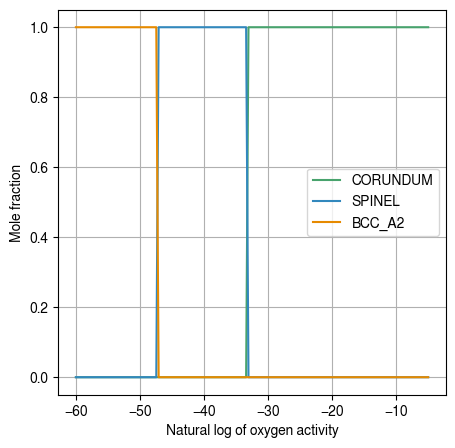

In [ ]:
# Filter the dataframe for rows where T is 573.15
filtered_df_FullEquil = df_FullEquil[df_FullEquil['T'] == 573.15]
filtered_df_FullEquil.to_excel(os.path.join(current_directory,
                                            "tc_df_FullEquil_check_filter.xlsx"), index=False)

plt.figure(figsize=(5, 5))
colors = {
    'CORUNDUM': '#48A36D',
    'SPINEL': '#3288BD',
    'HALITE': '#756BB1',
    'BCC_A2': '#E68A00',
}
labels_list = ['Hematite', 'Magnetite', 'Wustite', 'BCC Iron']

plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(CORUNDUM)'],
         color=colors['CORUNDUM'], label='CORUNDUM')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(SPINEL)'],
         color=colors['SPINEL'], label='SPINEL')
# plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(HALITE)'],
#          color=colors['HALITE'], label='HALITE')
plt.plot(filtered_df_FullEquil['lnacr_o'], filtered_df_FullEquil['np(BCC_A2)'],
         color=colors['BCC_A2'], label='BCC_A2')

plt.xlabel('Natural log of oxygen activity')
plt.ylabel('Mole fraction')
plt.grid(True)
plt.legend()
# plt.xlim(-100, -25)
plt.show()

### FullEquil: mapping for one phase


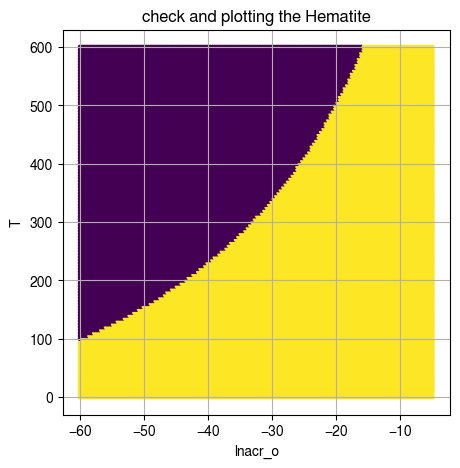

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(df_FullEquil['lnacr_o'], df_FullEquil['T']-273.15,
            c=df_FullEquil['np(CORUNDUM)'], s=6,  alpha=1)
plt.xlabel(df_FullEquil.columns[0])
plt.ylabel(df_FullEquil.columns[1])
plt.grid(True)
plt.title('check and plotting the Hematite')
plt.show()

### FullEquil: Mapping for all phases


In [ ]:
# Splitting the main dataframe into individual dataframes and filtering them
df_FullEquil_CORUNDUM = df_FullEquil[['lnacr_o', 'T', 'np(CORUNDUM)']]
df_FullEquil_CORUNDUM = df_FullEquil_CORUNDUM[
    df_FullEquil_CORUNDUM['np(CORUNDUM)'] >= 0.001]

df_FullEquil_SPINEL = df_FullEquil[['lnacr_o', 'T', 'np(SPINEL)']]
df_FullEquil_SPINEL = df_FullEquil_SPINEL[
    df_FullEquil_SPINEL['np(SPINEL)'] >= 0.001]

df_FullEquil_HALITE = df_FullEquil[['lnacr_o', 'T', 'np(HALITE)']]
df_FullEquil_HALITE = df_FullEquil_HALITE[df_FullEquil_HALITE['np(HALITE)']
                                          >= 0.001]

df_FullEquil_BCC_A2 = df_FullEquil[['lnacr_o', 'T', 'np(BCC_A2)']]
df_FullEquil_BCC_A2 = df_FullEquil_BCC_A2[df_FullEquil_BCC_A2['np(BCC_A2)']
                                          >= 0.001]

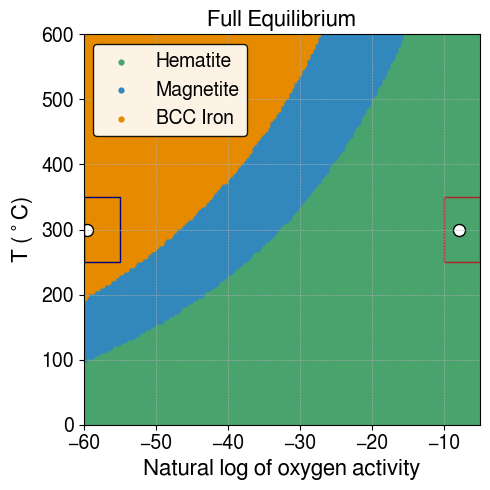

In [ ]:
from matplotlib.patches import Rectangle

# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for i, phase in enumerate(phases_list):
    if phase == "HALITE":
        pass
    else:
        df = globals()[f'df_FullEquil_{phase}']
        plt.scatter(df['lnacr_o'], df['T']-273.15, s=12,
                    label=labels_list[i],
                    color=colors[phase], alpha=1)

plt.scatter([-7.9663978], [300], facecolors='white',
            edgecolors='black', linewidths=1, s=75)
plt.scatter([-59.5], [300], facecolors='white',
            edgecolors='black', linewidths=1, s=75)

plt.xlabel('Natural log of oxygen activity', fontsize=16)
plt.ylabel(r'T ($^\circ$C)', fontsize=16)
plt.title('Full Equilibrium', fontsize=16)
plt.legend(fontsize=14, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
plt.ylim([min(df_Gmin['T'])-273.15, max(df_Gmin['T'])-273.15])
plt.yticks(range(0, 601, 100))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

# Define coordinates and dimensions of the first rectangle
rect_x, rect_y = -10, 250
rect_width, rect_height = 5, 100
rect1 = Rectangle((rect_x, rect_y), rect_width, rect_height,
                  linewidth=1, edgecolor='firebrick', facecolor='none')
plt.gca().add_patch(rect1)

# Define coordinates and dimensions of the second rectangle
rect_x, rect_y = -60, 250
rect_width, rect_height = 5, 100
rect2 = Rectangle((rect_x, rect_y), rect_width, rect_height,
                  linewidth=1, edgecolor='navy', facecolor='none')
plt.gca().add_patch(rect2)

# Save the figure
plt_output_fname = "_FullEquil.png"
plt.savefig(os.path.join(current_directory, output_fname + plt_output_fname),
            format='png', dpi=300, bbox_inches='tight')
plt.show()

### Gmin: mapping for individual phase


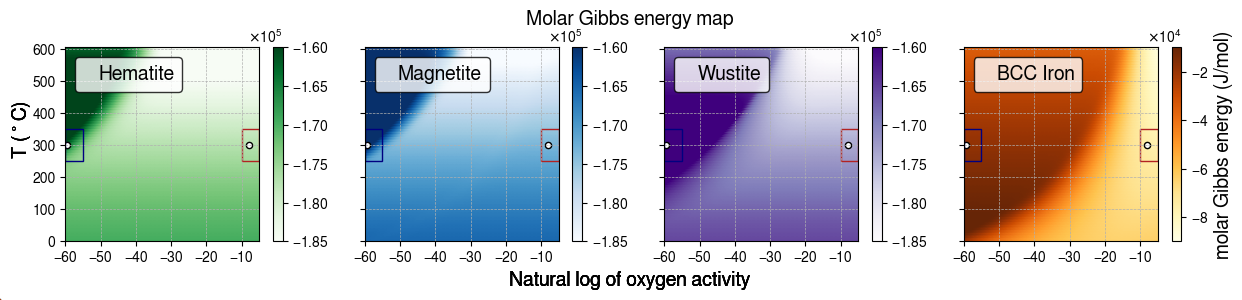

In [ ]:
from utils import plot_phases

func = 'gm'
colormaps = {
    'CORUNDUM': ('Greens',  -1.85e5, -1.6e5),
    'SPINEL':   ('Blues',   -1.85e5, -1.6e5),
    'HALITE':   ('Purples', -1.85e5, -1.6e5),
    'BCC_A2':   ('YlOrBr',  -9e4, -1e4),
}
use_defined_range = True
cbar_label = 'molar Gibbs energy (J/mol)'
title = 'Molar Gibbs energy map'
xlim, ylim, alpha = (-60, -5, 10), (0, 605, 100), 1
s_base, s_highlight = 10, 20
save_plot = True
plt_output_fname = "_Gm_phases.png"
plot_phases(phases_list, df_Gmin, func, labels_list,
            colormaps, use_defined_range, cbar_label, title,
            xlim, ylim, alpha, s_base, s_highlight,
            save_plot, current_directory, output_fname, plt_output_fname)

### Gmin: Mapping for all phases


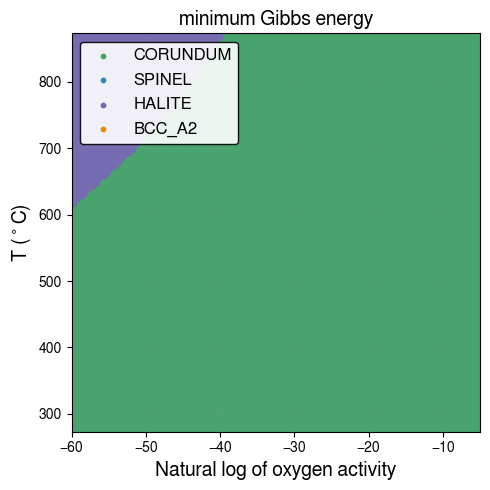

In [ ]:
columns_to_compare = [f'gm({phase})' for phase in phases_list]

for phase in phases_list:
    column_name = f'gm({phase})'
    condition = df_Gmin[column_name] == df_Gmin[columns_to_compare].min(axis=1)
    globals()[f'df_Gmin_{phase}'] = df_Gmin[condition]

# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for phase in phases_list:
    df = globals()[f'df_Gmin_{phase}']
    plt.scatter(df['lnacr_o'], df['T'], s=10, label=phase,
                color=colors[phase], alpha=1)

plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('minimum Gibbs energy', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.1)
plt.xlim([min(df_Gmin['lnacr_o']), max(df_Gmin['lnacr_o'])])
plt.ylim([min(df_Gmin['T']), max(df_Gmin['T'])])
plt.tight_layout()

# plt_output_fname = "_Gmin.png"
# plt.savefig(os.path.join(current_directory, output_fname+plt_output_fname),
#             format='png', dpi=300,  bbox_inches='tight')
plt.show()

### NormDrivingForce: Mapping for individual phase


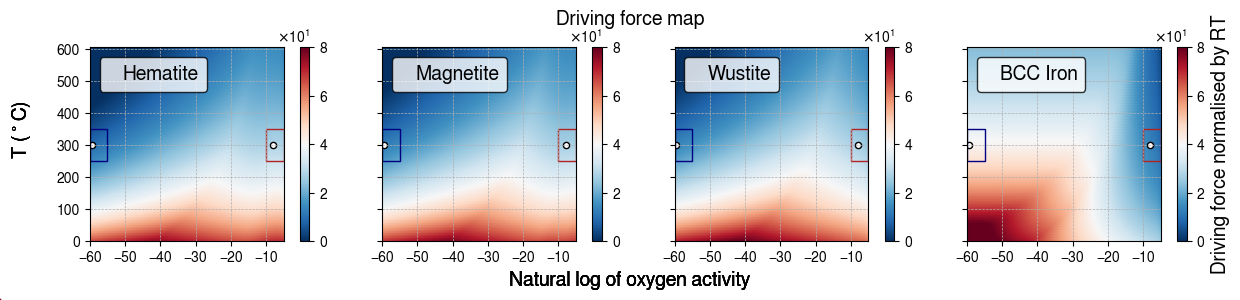

In [ ]:
from utils import plot_phases

func = 'dgm'
# colormaps = {
#     'CORUNDUM': ('Greens',  0, 80),
#     'SPINEL':   ('Blues',   0, 80),
#     'HALITE':   ('Purples', 0, 80),
#     'BCC_A2':   ('YlOrBr',  0, 80),
# }
colormaps = {
    'CORUNDUM': ('RdBu_r',  0, 80),
    'SPINEL':   ('RdBu_r',  0, 80),
    'HALITE':   ('RdBu_r',  0, 80),
    'BCC_A2':   ('RdBu_r',  0, 80),
}

use_defined_range = True
cbar_label = 'Driving force normalised by RT'
title = 'Driving force map'
xlim, ylim, alpha = (-60, -5, 10), (0, 605, 100), 1
s_base, s_highlight = 10, 20
save_plot = True
plt_output_fname = "_DGM_phases_full.png"
plot_phases(phases_list, df_DGM, func, labels_list,
            colormaps, use_defined_range, cbar_label, title,
            xlim, ylim, alpha, s_base, s_highlight,
            save_plot, current_directory, output_fname, plt_output_fname)

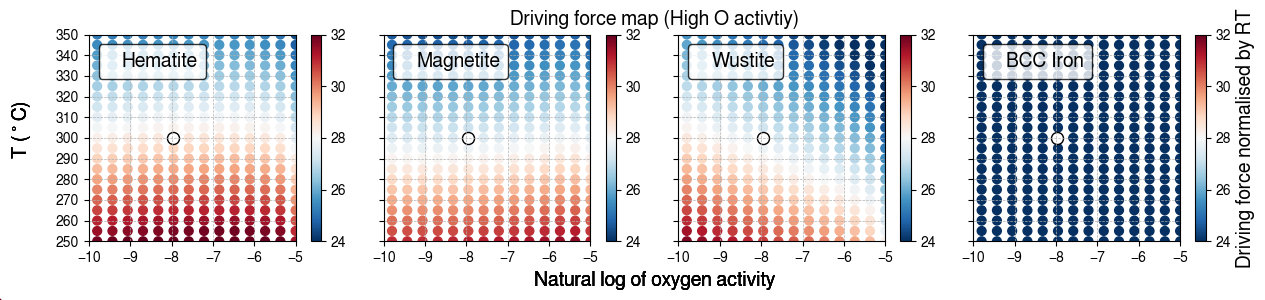

In [ ]:
from utils import plot_phases_crop

phases_list_sel = phases_list
labels_list_sel = labels_list
func = 'dgm'
colormaps = {
    'CORUNDUM': ('RdBu_r',  24, 32),
    'SPINEL':   ('RdBu_r',  24, 32),
    'HALITE':   ('RdBu_r',  24, 32),
    'BCC_A2':   ('RdBu_r',  24, 32),
}

use_defined_range = True
cbar_label = 'Driving force normalised by RT'
title = 'Driving force map (High O activtiy)'
xlim, ylim, alpha = (-10, -5, 1), (250, 350, 10), 1
s_base, s_highlight = 40, 75
save_plot = True
plt_output_fname = "_DGM_phases_highO.png"
plot_phases_crop(phases_list_sel, df_DGM, func, labels_list_sel,
                 colormaps, use_defined_range, cbar_label, title,
                 xlim, ylim, alpha, s_base, s_highlight,
                 save_plot, current_directory, output_fname, plt_output_fname)

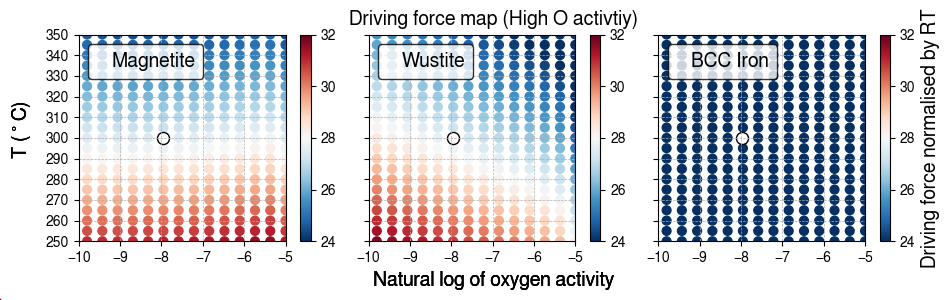

In [ ]:
from utils import plot_phases_crop

phases_list_sel = ['SPINEL', 'HALITE', 'BCC_A2']
labels_list_sel = ['Magnetite', 'Wustite', 'BCC Iron']
func = 'dgm'
colormaps = {
    'CORUNDUM': ('RdBu_r',  24, 32),
    'SPINEL':   ('RdBu_r',  24, 32),
    'HALITE':   ('RdBu_r',  24, 32),
    'BCC_A2':   ('RdBu_r',  24, 32),
}

use_defined_range = True
cbar_label = 'Driving force normalised by RT'
title = 'Driving force map (High O activtiy)'
xlim, ylim, alpha = (-10, -5, 1), (250, 350, 10), 1
s_base, s_highlight = 40, 75
save_plot = True
plt_output_fname = "_DGM_phases_highO_sel.png"
plot_phases_crop(phases_list_sel, df_DGM, func, labels_list_sel,
                 colormaps, use_defined_range, cbar_label, title,
                 xlim, ylim, alpha, s_base, s_highlight,
                 save_plot, current_directory, output_fname, plt_output_fname)

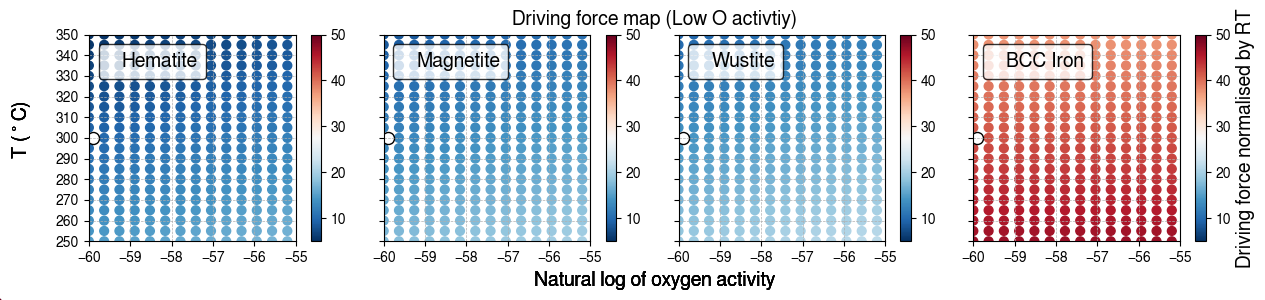

In [ ]:
from utils import plot_phases_crop

phases_list_sel = phases_list
labels_list_sel = labels_list
func = 'dgm'
colormaps = {
    'CORUNDUM': ('RdBu_r',  5, 50),
    'SPINEL':   ('RdBu_r',  5, 50),
    'HALITE':   ('RdBu_r',  5, 50),
    'BCC_A2':   ('RdBu_r',  5, 50),
}

use_defined_range = True
cbar_label = 'Driving force normalised by RT'
title = 'Driving force map (Low O activtiy)'
xlim, ylim, alpha = (-60, -55, 1), (250, 350, 10), 1
s_base, s_highlight = 40, 75
save_plot = True
plt_output_fname = "_DGM_phases_lowO.png"
plot_phases_crop(phases_list_sel, df_DGM, func, labels_list_sel,
                 colormaps, use_defined_range, cbar_label, title,
                 xlim, ylim, alpha, s_base, s_highlight,
                 save_plot, current_directory, output_fname, plt_output_fname)

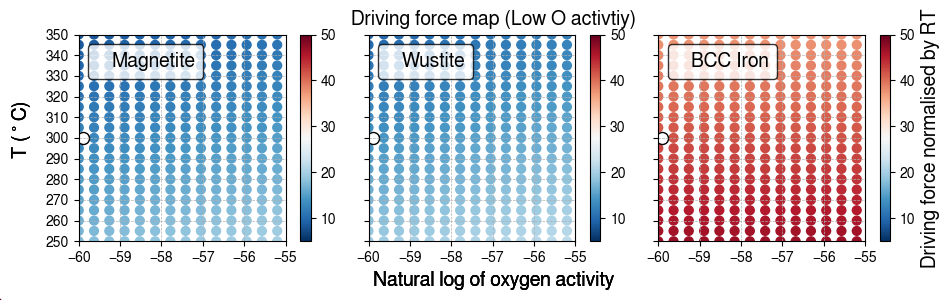

In [ ]:
from utils import plot_phases_crop

phases_list_sel = ['SPINEL', 'HALITE', 'BCC_A2']
labels_list_sel = ['Magnetite', 'Wustite', 'BCC Iron']
func = 'dgm'
colormaps = {
    'CORUNDUM': ('RdBu_r',  5, 50),
    'SPINEL':   ('RdBu_r',  5, 50),
    'HALITE':   ('RdBu_r',  5, 50),
    'BCC_A2':   ('RdBu_r',  5, 50),
}

use_defined_range = True
cbar_label = 'Driving force normalised by RT'
title = 'Driving force map (Low O activtiy)'
xlim, ylim, alpha = (-60, -55, 1), (250, 350, 10), 1
s_base, s_highlight = 40, 75
save_plot = True
plt_output_fname = "_DGM_phases_lowO_sel.png"
plot_phases_crop(phases_list_sel, df_DGM, func, labels_list_sel,
                 colormaps, use_defined_range, cbar_label, title,
                 xlim, ylim, alpha, s_base, s_highlight,
                 save_plot, current_directory, output_fname, plt_output_fname)

### DGM: Mapping for all phases


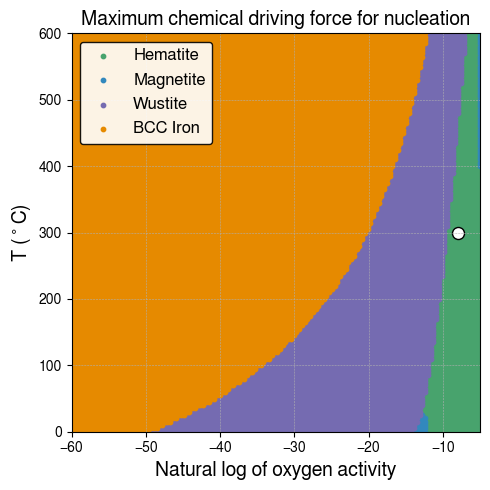

In [ ]:
columns_to_compare = [f'dgm({phase})' for phase in phases_list]
# columns_to_compare = ['dgm(SPINEL)', 'dgm(HALITE)']

for phase in phases_list:
    column_name = f'dgm({phase})'
    condition = df_DGM[column_name] == df_DGM[columns_to_compare].max(axis=1)
    globals()[f'df_DGM_{phase}'] = df_DGM[condition]


# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for i, phase in enumerate(phases_list):

    df = globals()[f'df_DGM_{phase}']
    plt.scatter(df['lnacr_o'], df['T']-273.15, s=10, label=labels_list[i],
                color=colors[phase], alpha=1)
plt.scatter([-7.9663978], [300],
            facecolors='white', edgecolors='black', linewidths=1, s=75)

plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('Maximum chemical driving force for nucleation', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.xlim([min(df_DGM['lnacr_o']), max(df_DGM['lnacr_o'])])
plt.ylim([min(df_DGM['T'])-273.15, max(df_DGM['T'])-273.15])
plt.tight_layout()

plt_output_fname = "_DGMmax.png"
plt.savefig(os.path.join(current_directory, output_fname+plt_output_fname),
            format='png', dpi=300, bbox_inches='tight')
plt.show()

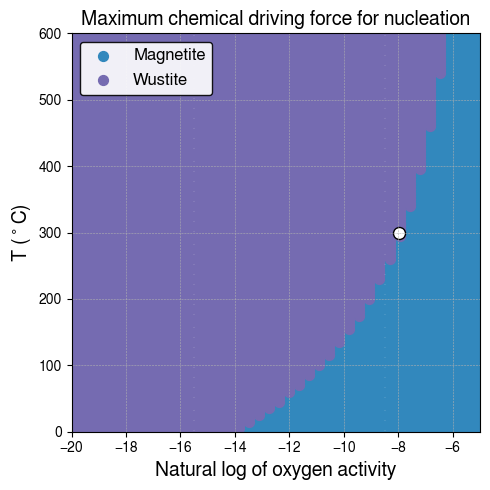

In [ ]:
# columns_to_compare = [f'dgm({phase})' for phase in phases_list]
columns_to_compare = ['dgm(SPINEL)', 'dgm(HALITE)']

for phase in phases_list:
    column_name = f'dgm({phase})'
    condition = df_DGM[column_name] == df_DGM[columns_to_compare].max(axis=1)
    globals()[f'df_DGM_{phase}'] = df_DGM[condition]

# Plotting the individual dataframes
plt.figure(figsize=(5, 5))

for i, phase in enumerate(phases_list):
    if phase == 'CORUNDUM' or phase == 'BCC_A2':
        pass
    else:
        df = globals()[f'df_DGM_{phase}']
        plt.scatter(df['lnacr_o'], df['T']-273.15, s=50, label=labels_list[i],
                    color=colors[phase], alpha=1)
plt.scatter([-7.9663978], [300],
            facecolors='white', edgecolors='black', linewidths=1, s=75)

plt.xlabel('Natural log of oxygen activity', fontsize=14)
plt.ylabel(r'T ($^\circ$C)', fontsize=14)
plt.title('Maximum chemical driving force for nucleation', fontsize=14)
plt.legend(fontsize=12, loc='upper left',
           facecolor='white', edgecolor='black', framealpha=0.9)
plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.xlim([-20, -5])
plt.ylim([min(df_DGM['T'])-273.15, max(df_DGM['T'])-273.15])
plt.tight_layout()

plt_output_fname = "_DGMmax_MagnetiteVSWustite.png"
plt.savefig(os.path.join(current_directory, output_fname+plt_output_fname),
            format='png', dpi=300,  bbox_inches='tight')
plt.show()